In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv(r"/content/test_data.csv")

In [3]:
data.columns

Index(['Name of the product', 'Product Brand', 'categories',
       'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title'],
      dtype='object')

In [4]:
data.dtypes

,0
Name of the product,object
Product Brand,object
categories,object
primaryCategories,object
reviews.date,object
reviews.text,object
reviews.title,object


In [8]:
data.isnull().sum()

,0
Name of the product,0
Product Brand,0
categories,0
primaryCategories,0
reviews.date,0
reviews.text,0
reviews.title,3


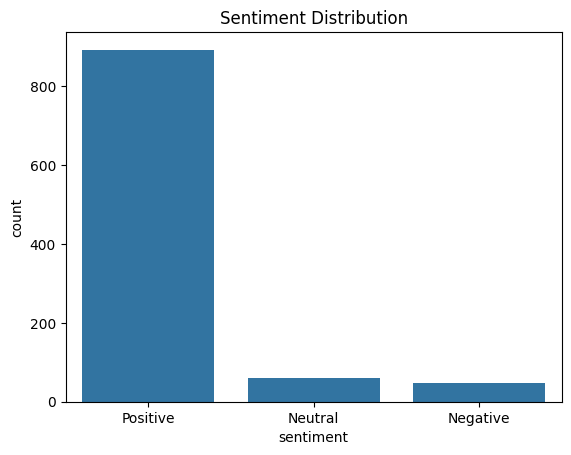

In [5]:
from textblob import TextBlob

# Function to classify sentiment
def get_sentiment(review):
    analysis = TextBlob(review)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

# Apply sentiment analysis to reviews.text
data['sentiment'] = data['reviews.text'].apply(get_sentiment)

# Now visualize the sentiment distribution
sns.countplot(x='sentiment', data=data)
plt.title('Sentiment Distribution')
plt.show()


In [6]:
# Display basic information
print(data.info())

# Display value counts for sentiment
print(data['sentiment'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Name of the product  1000 non-null   object
 1   Product Brand        1000 non-null   object
 2   categories           1000 non-null   object
 3   primaryCategories    1000 non-null   object
 4   reviews.date         1000 non-null   object
 5   reviews.text         1000 non-null   object
 6   reviews.title        997 non-null    object
 7   sentiment            1000 non-null   object
dtypes: object(8)
memory usage: 62.6+ KB
None
sentiment
Positive    892
Neutral      61
Negative     47
Name: count, dtype: int64


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize Tf-Idf Vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Transform review text into Tf-Idf features
X_tfidf = tfidf.fit_transform(data['reviews.text']).toarray()

# Display the shape of the resulting matrix
print(f"Tf-Idf matrix shape: {X_tfidf.shape}")


Tf-Idf matrix shape: (1000, 2827)


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Define features and target
X = X_tfidf
y = data['sentiment']

# Handle class imbalance using SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Predict and evaluate
y_pred = nb_classifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[181   0   0]
 [  0 181   0]
 [  3   7 164]]
              precision    recall  f1-score   support

    Negative       0.98      1.00      0.99       181
     Neutral       0.96      1.00      0.98       181
    Positive       1.00      0.94      0.97       174

    accuracy                           0.98       536
   macro avg       0.98      0.98      0.98       536
weighted avg       0.98      0.98      0.98       536



In [25]:
data.columns

Index(['Name of the product', 'Product Brand', 'categories',
       'primaryCategories', 'reviews.date', 'reviews.text', 'reviews.title',
       'sentiment'],
      dtype='object')

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        11
     Neutral       0.00      0.00      0.00         8
    Positive       0.91      1.00      0.95       181

    accuracy                           0.91       200
   macro avg       0.30      0.33      0.32       200
weighted avg       0.82      0.91      0.86       200

Confusion Matrix:
[[  0   0  11]
 [  0   0   8]
 [  0   0 181]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AUC-ROC Score: 0.8486015621528836


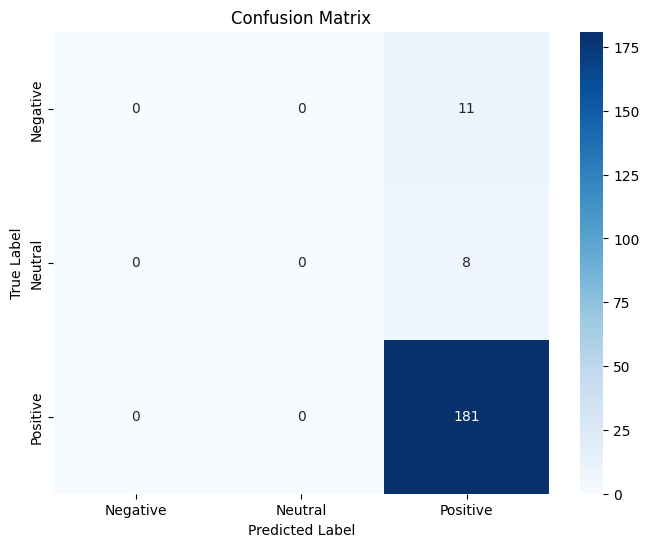

In [8]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline

# Assuming your data is already preprocessed and stored in X and y (features and labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, data['sentiment'], test_size=0.2, random_state=42)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Create a pipeline with SVM and SMOTE
model_svm = make_pipeline(SVC(probability=True))

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf'],
    'svc__gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(model_svm, param_grid, cv=3, verbose=1, n_jobs=-1, scoring='accuracy')

# Fit the model with the best parameters
grid_search.fit(X_train_res, y_train_res)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate AUC-ROC (for multi-class classification)
y_probs = best_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_probs, multi_class='ovr')
print(f"AUC-ROC Score: {roc_auc}")

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


Neural Network Classifier (with SMOTE):
              precision    recall  f1-score   support

    Negative       0.67      0.20      0.31        10
     Neutral       0.50      0.33      0.40        12
    Positive       0.92      0.98      0.95       178

    accuracy                           0.90       200
   macro avg       0.70      0.50      0.55       200
weighted avg       0.88      0.90      0.88       200

[[  2   0   8]
 [  1   4   7]
 [  0   4 174]]
AUC-ROC Score:  0.8336217275489015


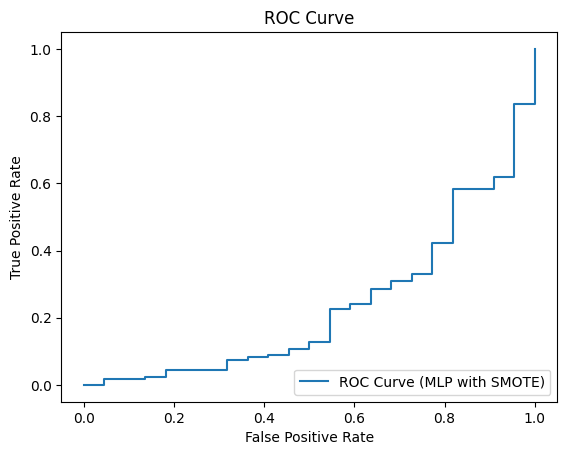

In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
# Define features and target
X = X_tfidf
y = data['sentiment']
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Initialize and train the neural network model
model_mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
model_mlp.fit(X_train_smote, y_train_smote)

# Predict labels
y_pred_mlp = model_mlp.predict(X_test)

# Evaluate model
print("Neural Network Classifier (with SMOTE):")
print(classification_report(y_test, y_pred_mlp))
print(confusion_matrix(y_test, y_pred_mlp))

# Calculate AUC-ROC
roc_auc_mlp = roc_auc_score(y_test, model_mlp.predict_proba(X_test), multi_class='ovr')
print("AUC-ROC Score: ", roc_auc_mlp)

# Calculate ROC curve
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, model_mlp.predict_proba(X_test)[:, 1], pos_label='Positive')
plt.plot(fpr_mlp, tpr_mlp, label="ROC Curve (MLP with SMOTE)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


XGBoost Classifier:
              precision    recall  f1-score   support

    Negative       0.50      0.10      0.17        10
     Neutral       0.75      0.25      0.38        12
    Positive       0.91      0.99      0.95       178

    accuracy                           0.90       200
   macro avg       0.72      0.45      0.50       200
weighted avg       0.88      0.90      0.87       200

[[  1   0   9]
 [  0   3   9]
 [  1   1 176]]
AUC-ROC Score:  0.8897385146557234


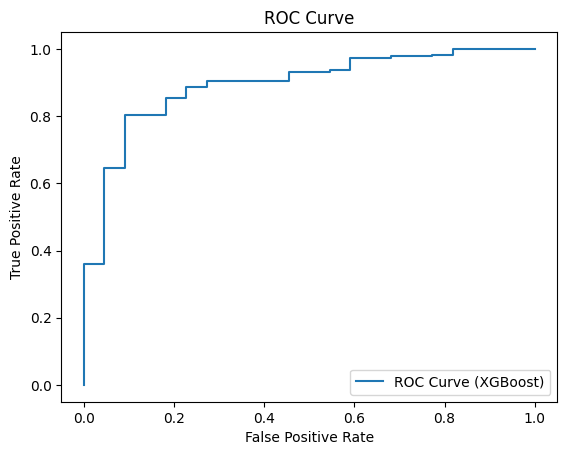

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# Encode target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Initialize and train the XGBoost model
model_xgb = XGBClassifier(eval_metric='mlogloss')
model_xgb.fit(X_train, y_train_encoded)

# Predict labels
y_pred_xgb = model_xgb.predict(X_test)

# Decode predictions back to original labels
y_pred_xgb_decoded = label_encoder.inverse_transform(y_pred_xgb)

# Evaluate model
print("XGBoost Classifier:")
print(classification_report(y_test, y_pred_xgb_decoded))
print(confusion_matrix(y_test, y_pred_xgb_decoded))

# Calculate AUC-ROC
roc_auc_xgb = roc_auc_score(y_test_encoded, model_xgb.predict_proba(X_test), multi_class='ovr')
print("AUC-ROC Score: ", roc_auc_xgb)

# For ROC curve, you need to specify the class index (e.g., Positive class)
class_index = list(label_encoder.classes_).index('Positive')
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_encoded, model_xgb.predict_proba(X_test)[:, class_index], pos_label=class_index)
plt.plot(fpr_xgb, tpr_xgb, label="ROC Curve (XGBoost)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


XGBoost Classifier with SMOTE:
              precision    recall  f1-score   support

    Negative       0.40      0.18      0.25        11
     Neutral       0.00      0.00      0.00         8
    Positive       0.92      0.96      0.94       181

    accuracy                           0.88       200
   macro avg       0.44      0.38      0.40       200
weighted avg       0.85      0.88      0.86       200

[[  2   1   8]
 [  0   0   8]
 [  3   5 173]]
AUC-ROC Score:  0.7999987750946803


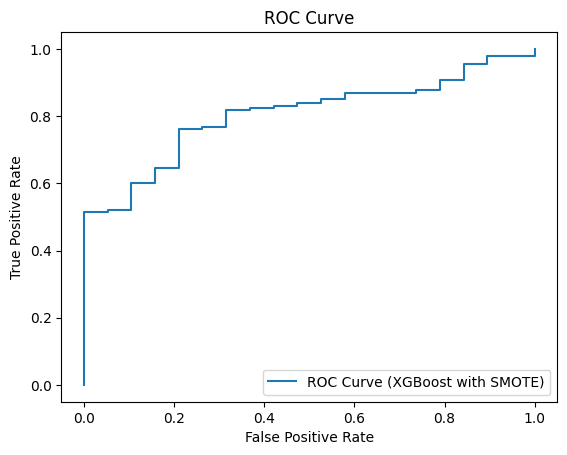

In [15]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Example data splitting (replace with your actual data splitting if needed)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Encode target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train_encoded)

# Initialize and train the XGBoost model
model_xgb = XGBClassifier(eval_metric='mlogloss')
model_xgb.fit(X_train_smote, y_train_smote)

# Predict labels
y_pred_xgb = model_xgb.predict(X_test)

# Decode predictions back to original labels
y_pred_xgb_decoded = label_encoder.inverse_transform(y_pred_xgb)

# Evaluate model
print("XGBoost Classifier with SMOTE:")
print(classification_report(y_test, y_pred_xgb_decoded))
print(confusion_matrix(y_test, y_pred_xgb_decoded))

# Calculate AUC-ROC
roc_auc_xgb = roc_auc_score(y_test_encoded, model_xgb.predict_proba(X_test), multi_class='ovr')
print("AUC-ROC Score: ", roc_auc_xgb)

# For ROC curve, use the appropriate class index
class_index = list(label_encoder.classes_).index('Positive')
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_encoded, model_xgb.predict_proba(X_test)[:, class_index], pos_label=class_index)
plt.plot(fpr_xgb, tpr_xgb, label="ROC Curve (XGBoost with SMOTE)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 970ms/step - accuracy: 0.4004 - loss: 1.0857 - val_accuracy: 0.5093 - val_loss: 1.0352
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 37s 833ms/step - accuracy: 0.5436 - loss: 0.9308 - val_accuracy: 0.5654 - val_loss: 0.8408
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 957ms/step - accuracy: 0.6815 - loss: 0.6875 - val_accuracy: 0.5864 - val_loss: 0.9035
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 939ms/step - accuracy: 0.7711 - loss: 0.5181 - val_accuracy: 0.6098 - val_loss: 0.9005
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 958ms/step - accuracy: 0.8698 - loss: 0.3573 - val_accuracy: 0.6192 - val_loss: 1.0670
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step
Confusion Matrix:
[[ 74  86  21]
 [ 19 114  48]
 [ 21  44 109]]

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.41      0.50       181
           1       0.47      0.63      0.54       181
           2       0.61      0.63      0.62       174

    accu

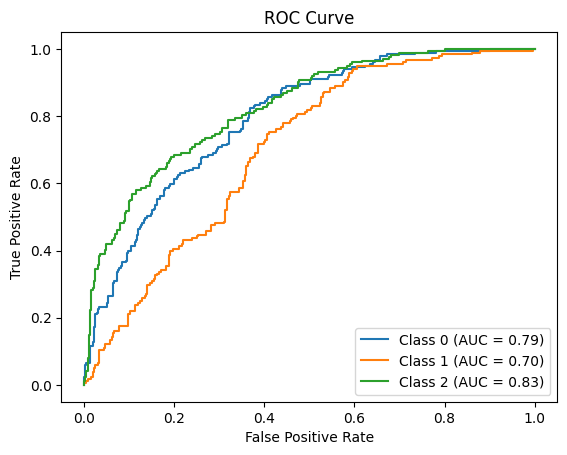

In [22]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['reviews.text'])
X_tokenized = tokenizer.texts_to_sequences(data['reviews.text'])
X_padded = pad_sequences(X_tokenized, maxlen=200)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_padded, data['sentiment'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Encode the target variable
y_train_binarized = label_binarize(y_train, classes=np.unique(y_resampled))
y_test_binarized = label_binarize(y_test, classes=np.unique(y_resampled))

# Build the LSTM model
model_lstm = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=200),
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    LSTM(64),
    Dense(3, activation='softmax')  # Adjust based on the number of classes
])

# Compile the model
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_lstm.fit(X_train, y_train_binarized, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Predict and evaluate
y_pred_proba = model_lstm.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_test_classes = np.argmax(y_test_binarized, axis=1)

print("Confusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred))
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred))

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, average='macro', multi_class='ovr')
print("AUC-ROC Score:", roc_auc)

# Plot the ROC curve for each class
for i in range(y_test_binarized.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i]):.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


Confusion Matrix:
[[181   0   0]
 [  0 181   0]
 [  2  10 162]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      1.00      0.99       181
     Neutral       0.95      1.00      0.97       181
    Positive       1.00      0.93      0.96       174

    accuracy                           0.98       536
   macro avg       0.98      0.98      0.98       536
weighted avg       0.98      0.98      0.98       536

AUC-ROC Score: 0.9997334465078825


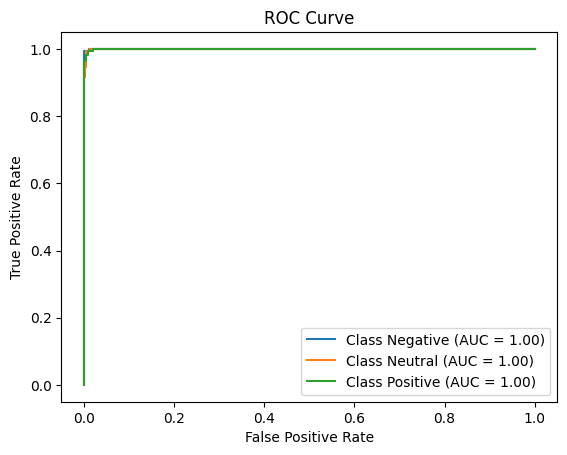

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Define features and target
X = X_tfidf
y = data['sentiment']

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Predict and evaluate
y_pred = nb_classifier.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculate AUC-ROC
y_test_binarized = label_binarize(y_test, classes=nb_classifier.classes_)
y_pred_proba = nb_classifier.predict_proba(X_test)

# For multi-class, calculate macro-average AUC-ROC
roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, average='macro', multi_class='ovr')
print("AUC-ROC Score:", roc_auc)

# Plot the ROC curve for each class
for i in range(len(nb_classifier.classes_)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f"Class {nb_classifier.classes_[i]} (AUC = {roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i]):.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
